In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['Device:', 'rrqm/s', 'wrqm/s', 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'avgrq-sz', 'avgqu-sz',
                  'await', 'r_await', 'w_await', 'svctm', '%util']
TEST_CONFIG = 'max-rate-submit'
DISK_CONFIG = 'ssd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['sdb', 'sdc', 'sdd', 'sde', 'sdf', 'sdg', 'sdh', 'sdi']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat_ns.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%util', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%util', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# ZFS on Linux #6566 Performance Results - Max Rate Submit on SSDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would issue the writes as quickly as possible; i.e. immediately after a thread's write would complete, it would issue the next write. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 32 vCPUs
 - 512 GB of RAM
 - Enterprise Solid State Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

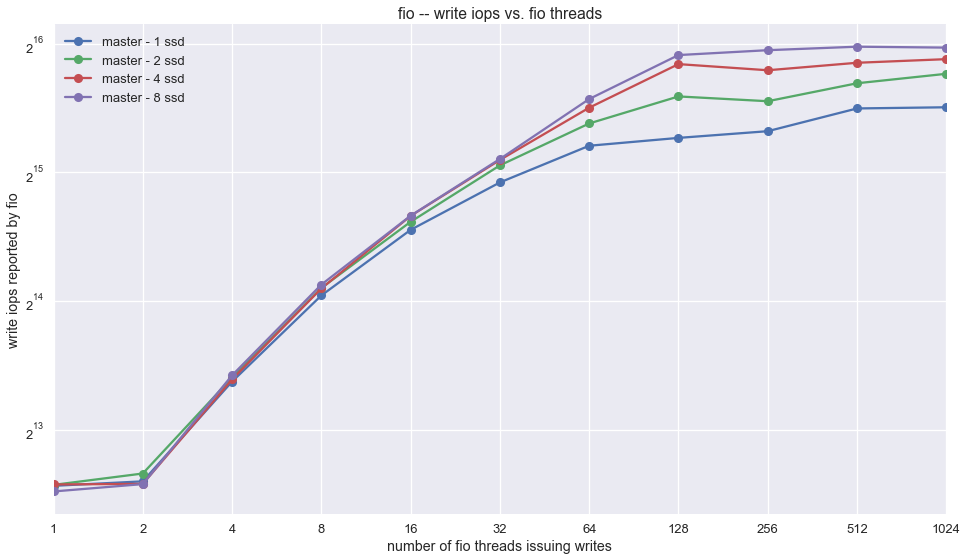

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,6056.349061,6087.115215,6100.848319,5875.052082
2,6203.779937,6471.725471,6120.431326,6112.964784
4,10618.489692,10847.469209,10743.637606,10981.016983
8,16886.218563,17582.073632,17536.341061,17902.586580
16,24046.631779,25113.379554,25924.302523,25946.268458
32,31043.579702,34030.932302,35042.381921,35222.425919
64,37826.675999,42650.334967,46433.408315,48651.039931
128,39460.228314,49333.994400,58717.052197,61648.740084
256,40910.425624,48077.815176,56804.849596,63290.620938
512,46243.375139,52960.822543,59141.831568,64491.367818


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

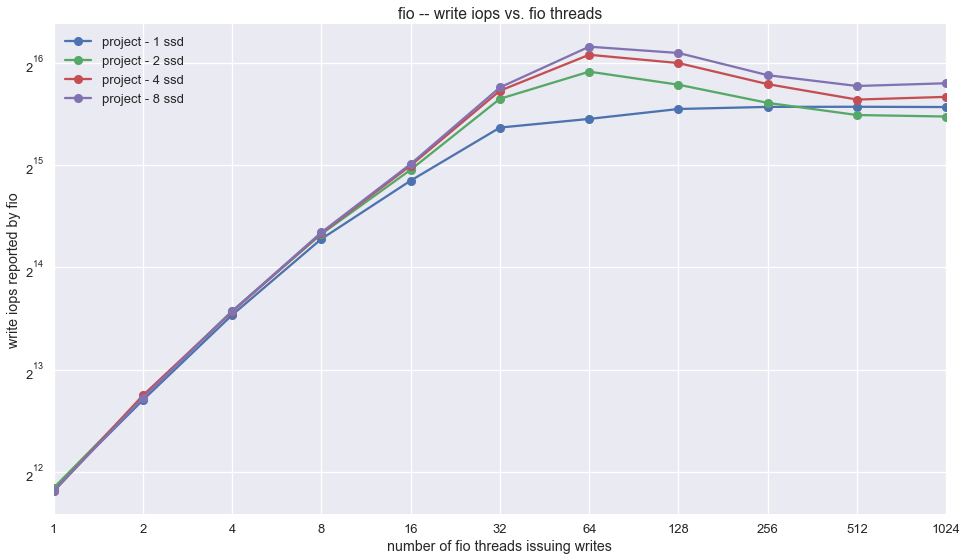

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,3644.222596,3670.805487,3585.473575,3587.973534
2,6654.672422,6781.157295,6869.385510,6764.537258
4,11848.769187,12169.980500,12113.512883,12155.764071
8,19838.219363,20506.215631,20627.895737,20735.554407
16,29451.784941,31701.476617,32624.262525,32969.150514
32,42195.140243,51279.562007,54162.783722,55385.680716
64,44746.925307,61632.718364,69101.699434,72985.903759
128,47857.773778,56412.997834,65329.478228,69944.027861
256,48543.445655,49877.261671,56629.165556,60173.391530
512,48583.224311,45939.229463,51011.105006,55925.993772


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

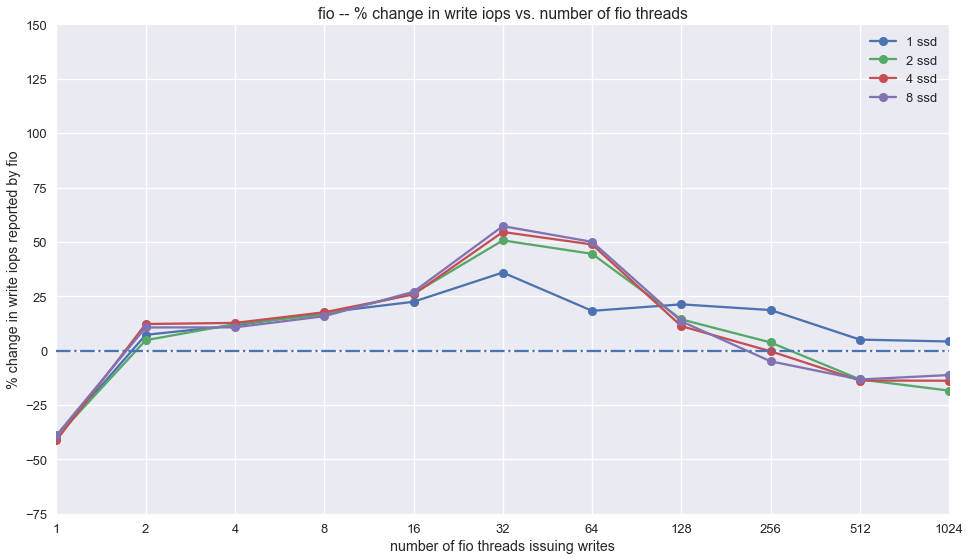

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-75, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 ssd,2 ssd,4 ssd,8 ssd
1,-39.828062,-39.695482,-41.229918,-38.928651
2,7.268028,4.781288,12.236951,10.658862
4,11.586200,12.191888,12.750572,10.697981
8,17.481716,16.631383,17.629417,15.824349
16,22.477797,26.233415,25.844321,27.067021
32,35.922277,50.685152,54.563648,57.245503
64,18.294627,44.506997,48.818926,50.019206
128,21.281036,14.349139,11.261509,13.455730
256,18.657885,3.742779,-0.309276,-4.925263
512,5.059858,-13.258089,-13.747844,-13.281427


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

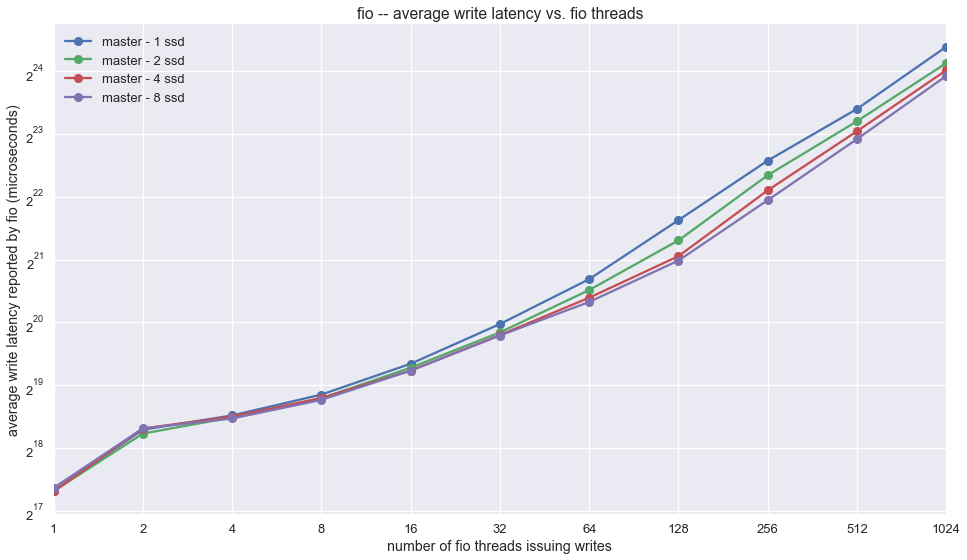

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,1.634320e+05,1.626818e+05,1.622611e+05,1.685656e+05
2,3.206503e+05,3.073132e+05,3.249258e+05,3.253889e+05
4,3.754653e+05,3.674779e+05,3.710711e+05,3.630510e+05
8,4.726764e+05,4.539664e+05,4.551668e+05,4.458078e+05
16,6.642700e+05,6.360634e+05,6.161254e+05,6.156146e+05
32,1.029556e+06,9.391422e+05,9.120266e+05,9.073438e+05
64,1.690424e+06,1.499122e+06,1.376952e+06,1.314203e+06
128,3.241785e+06,2.592765e+06,2.178316e+06,2.074708e+06
256,6.254457e+06,5.321537e+06,4.504116e+06,4.042400e+06
512,1.106624e+07,9.662017e+06,8.651920e+06,7.934605e+06


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

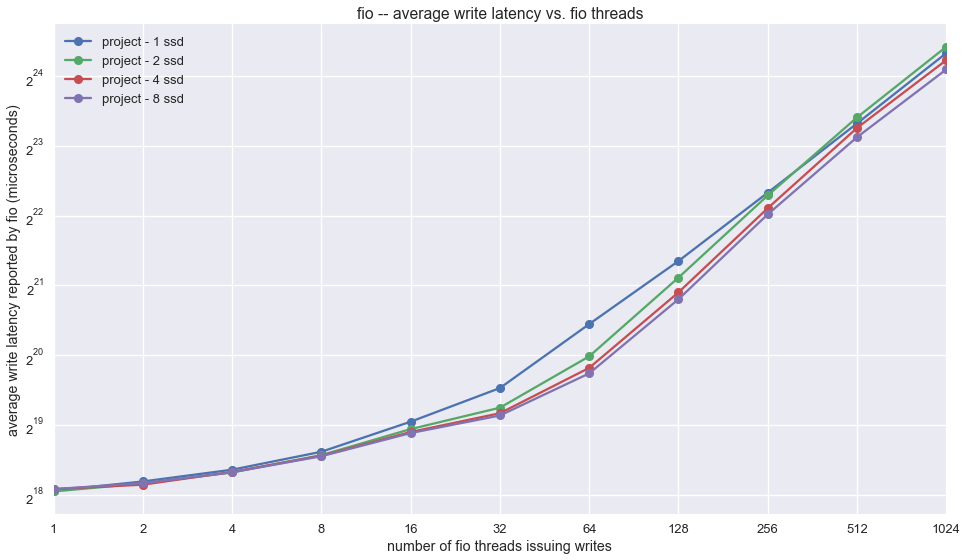

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,2.726606e+05,2.706092e+05,2.771413e+05,2.769303e+05
2,2.988132e+05,2.932227e+05,2.894533e+05,2.939649e+05
4,3.358907e+05,3.269556e+05,3.285516e+05,3.273957e+05
8,4.014587e+05,3.883788e+05,3.860536e+05,3.840481e+05
16,5.412651e+05,5.028651e+05,4.886039e+05,4.835039e+05
32,7.561537e+05,6.220327e+05,5.887969e+05,5.758232e+05
64,1.427696e+06,1.036090e+06,9.238585e+05,8.747113e+05
128,2.672000e+06,2.266187e+06,1.956765e+06,1.827536e+06
256,5.270541e+06,5.128061e+06,4.516623e+06,4.249967e+06
512,1.048588e+07,1.113338e+07,1.002702e+07,9.145640e+06


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

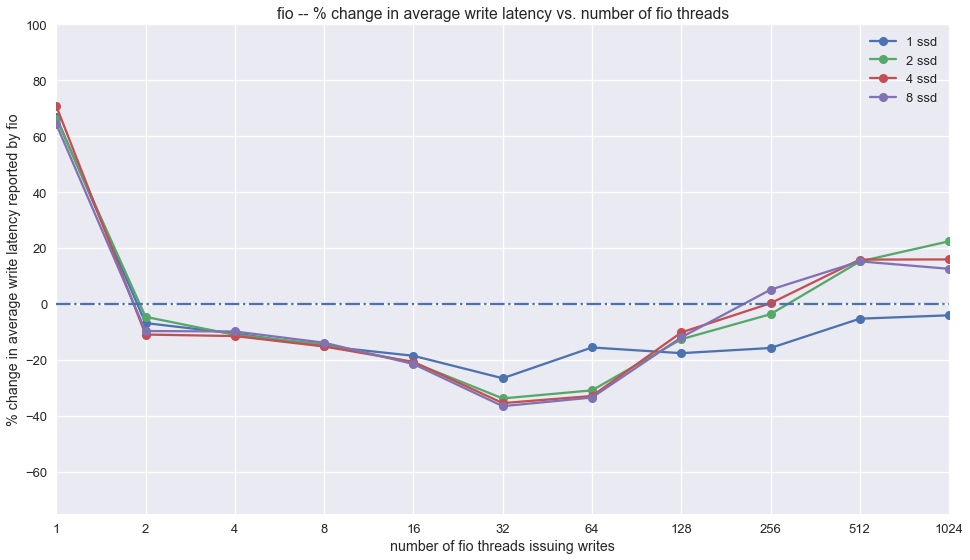

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-75, 100)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 ssd,2 ssd,4 ssd,8 ssd
1,66.834331,66.342679,70.799623,64.286374
2,-6.810240,-4.585077,-10.917115,-9.657367
4,-10.540152,-11.027158,-11.458601,-9.821014
8,-15.066894,-14.447663,-15.184151,-13.853438
16,-18.517310,-20.941048,-20.697339,-21.459966
32,-26.555354,-33.765868,-35.440817,-36.537482
64,-15.542146,-30.886878,-32.905559,-33.441690
128,-17.576290,-12.595737,-10.170758,-11.913569
256,-15.731435,-3.635715,0.277679,5.134768
512,-5.244370,15.228359,15.893635,15.262690


## `%util` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%util` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -x 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%util` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%util` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%util` averaged across all disks in zpool vs. `fio` threads - master branch

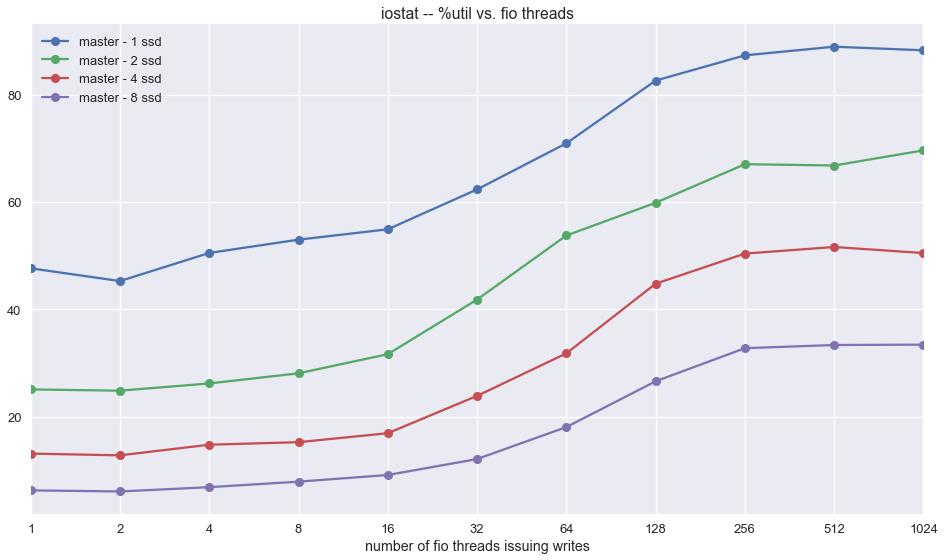

In [15]:
plot_iostat_column_dataframe(master_busy, '%util')

In [16]:
master_busy

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,47.658182,25.083636,13.120000,6.269091
2,45.280364,24.850909,12.798000,6.064545
4,50.523636,26.196364,14.775818,6.864182
8,52.999636,28.087273,15.250909,7.890909
16,54.928909,31.650909,16.921455,9.133091
32,62.363273,41.832727,23.876364,12.107091
64,70.960000,53.774909,31.805455,18.065455
128,82.654364,59.873091,44.790727,26.600727
256,87.353455,67.063636,50.402364,32.772000
512,88.965818,66.821455,51.632545,33.361273


### `%util` averaged across all disks in zpool vs. `fio` threads - project branch

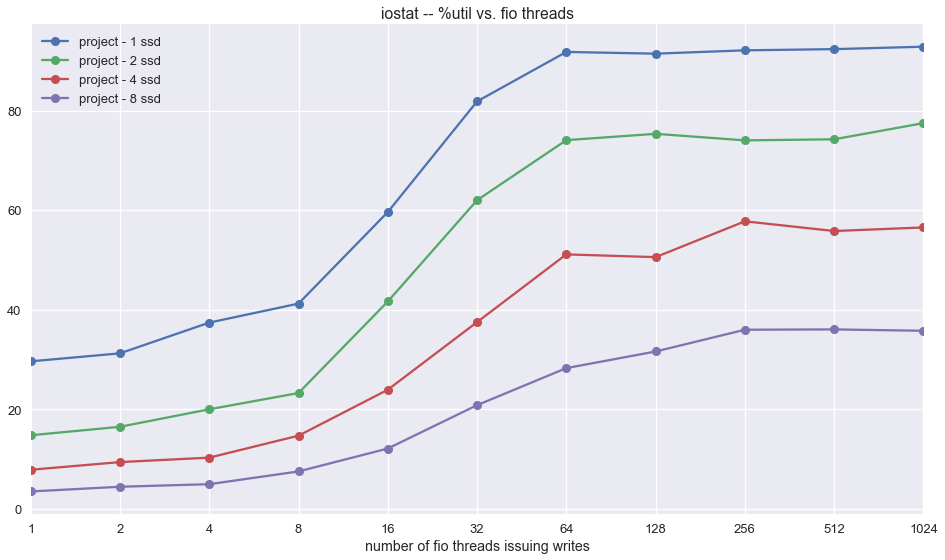

In [17]:
plot_iostat_column_dataframe(project_busy, '%util')

In [18]:
project_busy

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,29.621818,14.778182,7.847273,3.490909
2,31.231091,16.480000,9.389091,4.436364
4,37.403636,19.992727,10.282182,4.952727
8,41.220909,23.261273,14.695636,7.512727
16,59.607273,41.643091,23.917636,12.113636
32,81.832909,61.985455,37.506182,20.825273
64,91.765818,74.052909,51.105455,28.266364
128,91.416364,75.317273,50.552364,31.601636
256,92.089091,74.007818,57.746182,35.972364
512,92.328571,74.220364,55.800545,36.038545
